# 1.3 Portfolio Simulation with Position Sizing

Proper portfolio simulation with:
1. **Compounding** - reinvest gains/losses into subsequent trades
2. **Position sizing** - allocate X% of current NAV per trade
3. **Correct drawdown** - measured as % decline from peak equity

Compare different position sizing strategies:
- Fixed 5%, 10%, 20%, 50% of NAV per trade
- Kelly-inspired sizing (future)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

DATA_DIR = Path('../data/earnings')
INITIAL_NAV = 10_000  # Starting capital

## 1. Load Data

In [2]:
# Load OOS predictions
oos = pd.read_parquet(DATA_DIR / 'oos_predictions.parquet')
oos['earnings_date'] = pd.to_datetime(oos['earnings_date'])

print(f"Out-of-sample predictions: {len(oos)}")
print(f"Date range: {oos['earnings_date'].min().date()} to {oos['earnings_date'].max().date()}")

Out-of-sample predictions: 60270
Date range: 2022-01-10 to 2025-12-18


## 2. Portfolio Simulation Engine

In [3]:
def simulate_portfolio(
    df: pd.DataFrame,
    initial_nav: float = 10_000,
    position_size_pct: float = 0.10,  # 10% of NAV per trade
    edge_threshold: float = 0.07,
    spread_cost_pct: float = 0.03,
    max_trades_per_day: int = 5,
) -> pd.DataFrame:
    """
    Simulate portfolio with proper compounding and position sizing.
    
    Args:
        df: DataFrame with predictions (must have target_move, hist_move_mean, pred_q75)
        initial_nav: Starting capital
        position_size_pct: Fraction of current NAV to allocate per trade
        edge_threshold: Minimum edge (pred_q75 - implied) to trade
        spread_cost_pct: Round-trip spread cost
        max_trades_per_day: Maximum concurrent positions per day
    
    Returns:
        DataFrame with trade-by-trade results and equity curve
    """
    df = df.copy()
    
    # Calculate edge
    df['implied_move'] = df['hist_move_mean']
    df['edge'] = df['pred_q75'] - df['implied_move']
    
    # Filter to tradeable
    df['tradeable'] = df['edge'] > edge_threshold
    
    # Sort by date and edge (best edge first)
    df = df.sort_values(['earnings_date', 'edge'], ascending=[True, False])
    
    # Limit trades per day
    df['trade_rank'] = df.groupby('earnings_date').cumcount() + 1
    df['take_trade'] = df['tradeable'] & (df['trade_rank'] <= max_trades_per_day)
    
    # Get trades only
    trades = df[df['take_trade']].copy()
    trades = trades.sort_values('earnings_date').reset_index(drop=True)
    
    if len(trades) == 0:
        return pd.DataFrame()
    
    # Simulate with compounding
    nav = initial_nav
    peak_nav = initial_nav
    
    results = []
    
    for idx, row in trades.iterrows():
        # Position size based on current NAV
        position_value = nav * position_size_pct
        
        # P&L for this trade (as fraction of position)
        trade_return = row['target_move'] - row['implied_move'] - spread_cost_pct
        
        # Dollar P&L
        dollar_pnl = position_value * trade_return
        
        # Update NAV
        nav_before = nav
        nav = nav + dollar_pnl
        
        # Track peak for drawdown
        peak_nav = max(peak_nav, nav)
        
        # Drawdown from peak (as percentage)
        drawdown_pct = (nav - peak_nav) / peak_nav if peak_nav > 0 else 0
        
        results.append({
            'earnings_date': row['earnings_date'],
            'symbol': row['symbol'],
            'edge': row['edge'],
            'target_move': row['target_move'],
            'implied_move': row['implied_move'],
            'trade_return': trade_return,
            'position_value': position_value,
            'dollar_pnl': dollar_pnl,
            'nav_before': nav_before,
            'nav_after': nav,
            'peak_nav': peak_nav,
            'drawdown_pct': drawdown_pct,
        })
    
    return pd.DataFrame(results)

In [4]:
def compute_portfolio_metrics(results_df: pd.DataFrame, initial_nav: float) -> dict:
    """
    Compute key portfolio metrics from simulation results.
    """
    if len(results_df) == 0:
        return {}
    
    final_nav = results_df['nav_after'].iloc[-1]
    total_return = (final_nav - initial_nav) / initial_nav
    
    # Max drawdown (already computed as % from peak)
    max_drawdown = results_df['drawdown_pct'].min()
    
    # Win rate
    win_rate = (results_df['dollar_pnl'] > 0).mean()
    
    # Sharpe (annualized)
    daily_returns = results_df.groupby('earnings_date')['dollar_pnl'].sum()
    # Normalize by NAV at start of each day for proper return calculation
    daily_nav = results_df.groupby('earnings_date')['nav_before'].first()
    daily_return_pct = daily_returns / daily_nav
    
    n_days = len(daily_returns)
    n_calendar = (results_df['earnings_date'].max() - results_df['earnings_date'].min()).days
    trades_per_year = n_days * 252 / n_calendar if n_calendar > 0 else 100
    
    sharpe = 0
    if daily_return_pct.std() > 0:
        sharpe = (daily_return_pct.mean() / daily_return_pct.std()) * np.sqrt(trades_per_year)
    
    # CAGR
    years = n_calendar / 365 if n_calendar > 0 else 1
    cagr = (final_nav / initial_nav) ** (1 / years) - 1 if years > 0 else 0
    
    return {
        'n_trades': len(results_df),
        'initial_nav': initial_nav,
        'final_nav': final_nav,
        'total_return': total_return,
        'cagr': cagr,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'sharpe': sharpe,
        'calmar': cagr / abs(max_drawdown) if max_drawdown != 0 else 0,
    }

## 3. Compare Position Sizing Strategies

In [18]:
# Test different position sizes
POSITION_SIZES = [0.05, 0.10, 0.15, 0.20, 0.30, 0.50,1.5,2.0]
EDGE_THRESHOLD = 0.07  # Optimal from 1.2

all_results = {}
all_metrics = []

for pos_size in POSITION_SIZES:
    results = simulate_portfolio(
        oos,
        initial_nav=INITIAL_NAV,
        position_size_pct=pos_size,
        edge_threshold=EDGE_THRESHOLD,
        spread_cost_pct=0.03,
    )
    
    if len(results) > 0:
        all_results[pos_size] = results
        metrics = compute_portfolio_metrics(results, INITIAL_NAV)
        metrics['position_size'] = pos_size
        all_metrics.append(metrics)

metrics_df = pd.DataFrame(all_metrics)
print(f"=== Position Sizing Comparison ({EDGE_THRESHOLD:.0%} edge threshold) ===\n")
print(metrics_df.to_string(index=False, formatters={
    'position_size': '{:.0%}'.format,
    'initial_nav': '${:,.0f}'.format,
    'final_nav': '${:,.0f}'.format,
    'total_return': '{:+.1%}'.format,
    'cagr': '{:+.1%}'.format,
    'max_drawdown': '{:.1%}'.format,
    'win_rate': '{:.1%}'.format,
    'sharpe': '{:.2f}'.format,
    'calmar': '{:.2f}'.format,
}))

=== Position Sizing Comparison (7% edge threshold) ===

 n_trades initial_nav                        final_nav               total_return         cagr max_drawdown win_rate sharpe    calmar position_size
     1513     $10,000                          $61,932                    +519.3%       +59.0%        -3.7%    50.0%   3.22     15.85            5%
     1513     $10,000                         $366,416                   +3564.2%      +149.9%        -7.3%    50.0%   3.21     20.42           10%
     1513     $10,000                       $2,073,772                  +20637.7%      +288.4%       -10.9%    50.0%   3.21     26.58           15%
     1513     $10,000                      $11,241,027                 +112310.3%      +497.0%       -14.3%    50.0%   3.20     34.86           20%
     1513     $10,000                     $291,493,962                +2914839.6%     +1266.5%       -20.8%    50.0%   3.18     60.99           30%
     1513     $10,000                 $122,249,758,802  

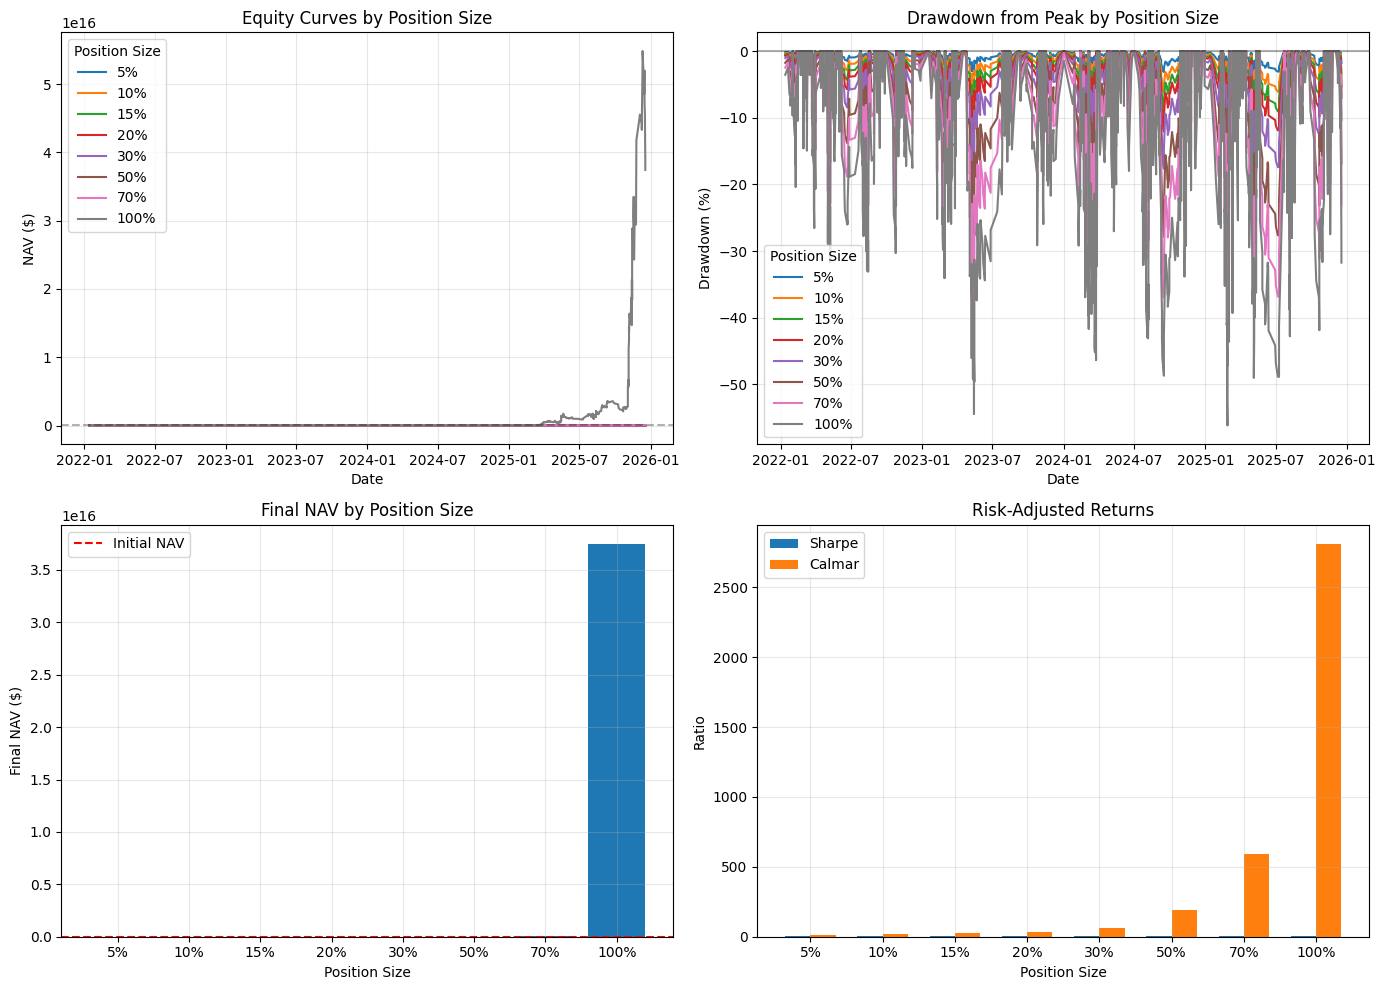

In [14]:
# Plot equity curves for different position sizes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Equity curves
ax = axes[0, 0]
for pos_size, results in all_results.items():
    ax.plot(results['earnings_date'], results['nav_after'], label=f'{pos_size:.0%}')
ax.axhline(INITIAL_NAV, color='black', linestyle='--', alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('NAV ($)')
ax.set_title('Equity Curves by Position Size')
ax.legend(title='Position Size')
ax.grid(True, alpha=0.3)

# Drawdowns
ax = axes[0, 1]
for pos_size, results in all_results.items():
    ax.plot(results['earnings_date'], results['drawdown_pct'] * 100, label=f'{pos_size:.0%}')
ax.axhline(0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown (%)')
ax.set_title('Drawdown from Peak by Position Size')
ax.legend(title='Position Size')
ax.grid(True, alpha=0.3)

# Final NAV bar chart
ax = axes[1, 0]
ax.bar(range(len(metrics_df)), metrics_df['final_nav'])
ax.set_xticks(range(len(metrics_df)))
ax.set_xticklabels([f"{p:.0%}" for p in metrics_df['position_size']])
ax.axhline(INITIAL_NAV, color='red', linestyle='--', label='Initial NAV')
ax.set_xlabel('Position Size')
ax.set_ylabel('Final NAV ($)')
ax.set_title('Final NAV by Position Size')
ax.legend()
ax.grid(True, alpha=0.3)

# Risk-adjusted metrics
ax = axes[1, 1]
x = range(len(metrics_df))
width = 0.35
ax.bar([i - width/2 for i in x], metrics_df['sharpe'], width, label='Sharpe')
ax.bar([i + width/2 for i in x], metrics_df['calmar'], width, label='Calmar')
ax.set_xticks(x)
ax.set_xticklabels([f"{p:.0%}" for p in metrics_df['position_size']])
ax.set_xlabel('Position Size')
ax.set_ylabel('Ratio')
ax.set_title('Risk-Adjusted Returns')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / 'position_sizing_comparison.png', dpi=100)
plt.show()

## 4. Detailed Analysis of Recommended Position Size

In [7]:
# Find best position size by Sharpe or Calmar
best_sharpe_idx = metrics_df['sharpe'].idxmax()
best_calmar_idx = metrics_df['calmar'].idxmax()

print("=== Optimal Position Sizing ===")
print(f"\nBest Sharpe: {metrics_df.loc[best_sharpe_idx, 'position_size']:.0%}")
print(f"  Sharpe: {metrics_df.loc[best_sharpe_idx, 'sharpe']:.2f}")
print(f"  Max DD: {metrics_df.loc[best_sharpe_idx, 'max_drawdown']:.1%}")
print(f"  CAGR: {metrics_df.loc[best_sharpe_idx, 'cagr']:.1%}")

print(f"\nBest Calmar: {metrics_df.loc[best_calmar_idx, 'position_size']:.0%}")
print(f"  Calmar: {metrics_df.loc[best_calmar_idx, 'calmar']:.2f}")
print(f"  Max DD: {metrics_df.loc[best_calmar_idx, 'max_drawdown']:.1%}")
print(f"  CAGR: {metrics_df.loc[best_calmar_idx, 'cagr']:.1%}")

=== Optimal Position Sizing ===

Best Sharpe: 5%
  Sharpe: 3.22
  Max DD: -3.7%
  CAGR: 59.0%

Best Calmar: 50%
  Calmar: 191.56
  Max DD: -32.6%
  CAGR: 6248.6%


In [8]:
# Detailed look at 10% position size (reasonable default)
SELECTED_SIZE = 0.10
selected_results = all_results.get(SELECTED_SIZE)

if selected_results is not None:
    print(f"=== Detailed Results ({SELECTED_SIZE:.0%} position size) ===\n")
    
    # Monthly returns
    selected_results['month'] = selected_results['earnings_date'].dt.to_period('M')
    monthly = selected_results.groupby('month').agg({
        'dollar_pnl': 'sum',
        'nav_after': 'last',
        'symbol': 'count',
    }).rename(columns={'symbol': 'n_trades'})
    
    # Monthly return %
    monthly['nav_start'] = monthly['nav_after'].shift(1).fillna(INITIAL_NAV)
    monthly['return_pct'] = monthly['dollar_pnl'] / monthly['nav_start']
    
    print("Monthly Performance:")
    print(monthly[['n_trades', 'dollar_pnl', 'return_pct']].tail(12).to_string(formatters={
        'dollar_pnl': '${:+,.0f}'.format,
        'return_pct': '{:+.1%}'.format,
    }))
    
    print(f"\nProfitable months: {(monthly['dollar_pnl'] > 0).sum()} / {len(monthly)}")
    print(f"Best month: ${monthly['dollar_pnl'].max():,.0f} ({monthly['return_pct'].max():.1%})")
    print(f"Worst month: ${monthly['dollar_pnl'].min():,.0f} ({monthly['return_pct'].min():.1%})")

=== Detailed Results (10% position size) ===

Monthly Performance:
         n_trades dollar_pnl return_pct
month                                  
2025-01         4    $-2,114      -1.5%
2025-02        43    $+3,273      +2.4%
2025-03        67   $+64,158     +45.6%
2025-04        36    $+5,777      +2.8%
2025-05        60   $+21,155     +10.0%
2025-06         9    $-2,720      -1.2%
2025-07        18   $+13,174      +5.8%
2025-08        51   $+23,466      +9.7%
2025-09        16    $+3,205      +1.2%
2025-10        17    $-3,656      -1.4%
2025-11        56  $+104,087     +39.2%
2025-12        17    $-2,901      -0.8%

Profitable months: 36 / 48
Best month: $104,087 (45.6%)
Worst month: $-3,656 (-2.0%)


## 5. Sensitivity to Edge Threshold

In [9]:
# Test different edge thresholds with fixed 10% position size
EDGE_THRESHOLDS = [0.03, 0.05, 0.07, 0.08, 0.10]
FIXED_POS_SIZE = 0.10

threshold_metrics = []

for thresh in EDGE_THRESHOLDS:
    results = simulate_portfolio(
        oos,
        initial_nav=INITIAL_NAV,
        position_size_pct=FIXED_POS_SIZE,
        edge_threshold=thresh,
        spread_cost_pct=0.03,
    )
    
    if len(results) > 0:
        metrics = compute_portfolio_metrics(results, INITIAL_NAV)
        metrics['edge_threshold'] = thresh
        threshold_metrics.append(metrics)

thresh_df = pd.DataFrame(threshold_metrics)
print(f"=== Edge Threshold Sensitivity ({FIXED_POS_SIZE:.0%} position size) ===\n")
print(thresh_df.to_string(index=False, formatters={
    'edge_threshold': '{:.0%}'.format,
    'final_nav': '${:,.0f}'.format,
    'total_return': '{:+.1%}'.format,
    'cagr': '{:+.1%}'.format,
    'max_drawdown': '{:.1%}'.format,
    'win_rate': '{:.1%}'.format,
    'sharpe': '{:.2f}'.format,
    'calmar': '{:.2f}'.format,
}))

=== Edge Threshold Sensitivity (10% position size) ===

 n_trades  initial_nav final_nav total_return    cagr max_drawdown win_rate sharpe calmar edge_threshold
     4093        10000   $41,965      +319.6%  +43.9%       -52.7%    39.6%   1.05   0.83             3%
     2959        10000  $149,392     +1393.9%  +98.8%       -21.6%    42.8%   2.03   4.58             5%
     1513        10000  $366,416     +3564.2% +149.9%        -7.3%    50.0%   3.21  20.42             7%
      924        10000  $209,075     +1990.8% +116.7%        -5.6%    54.2%   3.20  20.97             8%
      325        10000   $63,856      +538.6%  +60.4%        -3.7%    60.6%   2.73  16.21            10%


## 6. Risk of Ruin Analysis

In [10]:
# Check if any position size leads to ruin (NAV < 50% of initial)
RUIN_THRESHOLD = 0.50  # 50% of initial NAV

print("=== Risk of Ruin Analysis ===\n")

for pos_size, results in all_results.items():
    min_nav = results['nav_after'].min()
    min_nav_pct = min_nav / INITIAL_NAV
    hit_ruin = min_nav_pct < RUIN_THRESHOLD
    
    status = "RUIN" if hit_ruin else "OK"
    print(f"{pos_size:>5.0%}: Min NAV = ${min_nav:,.0f} ({min_nav_pct:.1%} of initial) [{status}]")

print(f"\nRuin threshold: {RUIN_THRESHOLD:.0%} of initial NAV")

=== Risk of Ruin Analysis ===

   5%: Min NAV = $9,931 (99.3% of initial) [OK]
  10%: Min NAV = $9,861 (98.6% of initial) [OK]
  15%: Min NAV = $9,791 (97.9% of initial) [OK]
  20%: Min NAV = $9,720 (97.2% of initial) [OK]
  30%: Min NAV = $9,576 (95.8% of initial) [OK]
  50%: Min NAV = $9,283 (92.8% of initial) [OK]

Ruin threshold: 50% of initial NAV


## 7. Summary & Recommendations

In [11]:
print("=" * 60)
print("PORTFOLIO SIMULATION SUMMARY")
print("=" * 60)

print(f"""
Initial NAV: ${INITIAL_NAV:,}
Edge threshold: {EDGE_THRESHOLD:.0%}
Spread cost: 3%

Key Findings:
""")

# Best options
conservative = metrics_df[metrics_df['position_size'] == 0.05].iloc[0] if 0.05 in metrics_df['position_size'].values else None
moderate = metrics_df[metrics_df['position_size'] == 0.10].iloc[0] if 0.10 in metrics_df['position_size'].values else None
aggressive = metrics_df[metrics_df['position_size'] == 0.20].iloc[0] if 0.20 in metrics_df['position_size'].values else None

if conservative is not None:
    print(f"Conservative (5% per trade):")
    print(f"  Final NAV: ${conservative['final_nav']:,.0f}")
    print(f"  Max Drawdown: {conservative['max_drawdown']:.1%}")
    print(f"  Sharpe: {conservative['sharpe']:.2f}")

if moderate is not None:
    print(f"\nModerate (10% per trade):")
    print(f"  Final NAV: ${moderate['final_nav']:,.0f}")
    print(f"  Max Drawdown: {moderate['max_drawdown']:.1%}")
    print(f"  Sharpe: {moderate['sharpe']:.2f}")

if aggressive is not None:
    print(f"\nAggressive (20% per trade):")
    print(f"  Final NAV: ${aggressive['final_nav']:,.0f}")
    print(f"  Max Drawdown: {aggressive['max_drawdown']:.1%}")
    print(f"  Sharpe: {aggressive['sharpe']:.2f}")

print(f"""
Recommendation:
- Start with 5-10% position size for Phase 0 validation
- Increase only after confirming fill rates and slippage
- Never exceed 20% per trade without proven calibration
""")

PORTFOLIO SIMULATION SUMMARY

Initial NAV: $10,000
Edge threshold: 7%
Spread cost: 3%

Key Findings:

Conservative (5% per trade):
  Final NAV: $61,932
  Max Drawdown: -3.7%
  Sharpe: 3.22

Moderate (10% per trade):
  Final NAV: $366,416
  Max Drawdown: -7.3%
  Sharpe: 3.21

Aggressive (20% per trade):
  Final NAV: $11,241,027
  Max Drawdown: -14.3%
  Sharpe: 3.20

Recommendation:
- Start with 5-10% position size for Phase 0 validation
- Increase only after confirming fill rates and slippage
- Never exceed 20% per trade without proven calibration



In [12]:
# Save best results
metrics_df.to_csv(DATA_DIR / 'position_sizing_results.csv', index=False)
print(f"Saved results to {DATA_DIR / 'position_sizing_results.csv'}")

Saved results to ../data/earnings/position_sizing_results.csv
